In [1]:
import pandas as pd

from ptls.preprocessing import PandasDataPreprocessor
from ptls.data_load.utils import collate_feature_dict
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.data_load.datasets.memory_dataset import MemoryMapDataset

from ptls.nn import TrxEncoder

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_parquet("data/preprocessed_new/churn.parquet")

In [3]:
df

,user_id,mcc_code,timestamp,amount,global_target,holiday_target,weekend_target,churn_target
0,0,19,2017-10-21 00:00:00,5023.0,0,0,1,0
1,0,2,2017-10-12 12:24:07,20000.0,0,0,0,0
2,0,10,2017-12-05 00:00:00,767.0,0,0,0,0
3,0,1,2017-10-21 00:00:00,2031.0,0,0,1,0
4,0,9,2017-10-24 13:14:24,36562.0,0,0,0,0
...,...,...,...,...,...,...,...,...
490508,10215,37,2016-12-17 00:00:00,2110.9,0,0,1,0
490509,10215,1,2016-12-16 00:00:00,31.0,0,0,0,0
490510,10215,1,2016-12-06 00:00:00,182.0,0,0,0,0
490511,10215,2,2016-12-06 13:39:49,5000.0,0,0,0,0


In [4]:
preproc = PandasDataPreprocessor(
    col_id="user_id",
    col_event_time="timestamp",
    event_time_transformation="dt_to_timestamp",
    cols_category=["mcc_code"],
    cols_numerical=["amount"],
    cols_first_item="global_target"
)

In [5]:
data = preproc.fit_transform(df)

In [6]:
dataset = MemoryMapDataset(data, [SeqLenFilter(15)])

In [7]:
train, test = train_test_split(dataset, test_size=0.1)

In [8]:
trx_encoder = TrxEncoder(
    embeddings={
        "mcc_code": {"in": 345, "out": 24}
    },
    numeric_values={
        "amount": "identity"
    }
)

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from models.dilated_conv import DilatedConvEncoder
from ptls.data_load import PaddedBatch

def generate_continuous_mask(B, T, n=5, l=0.1):
    res = torch.full((B, T), True, dtype=torch.bool)
    if isinstance(n, float):
        n = int(n * T)
    n = max(min(n, T // 2), 1)
    
    if isinstance(l, float):
        l = int(l * T)
    l = max(l, 1)
    
    for i in range(B):
        for _ in range(n):
            t = np.random.randint(T-l+1)
            res[i, t:t+l] = False
    return res

def generate_binomial_mask(B, T, p=0.5):
    return torch.from_numpy(np.random.binomial(1, p, size=(B, T))).to(torch.bool)

class TSEncoder(nn.Module):
    def __init__(self, trx_encoder, output_dims, depth=10, mask_mode='binomial'):
        super().__init__()
        self.trx_encoder = trx_encoder
        self.output_dims = output_dims
        self.hidden_dims = trx_encoder.output_size
        self.mask_mode = mask_mode
        # self.input_fc = nn.Linear(input_dims, hidden_dims)
        self.feature_extractor = DilatedConvEncoder(
            self.hidden_dims,
            [self.hidden_dims] * depth + [output_dims],
            kernel_size=3
        )
        self.repr_dropout = nn.Dropout(p=0.1)
        
    def forward(self, x, mask=None):  # x: B x T x input_dims
        if mask is None:
            if self.training:
                mask = self.mask_mode
            else:
                mask = 'all_true'
        
        if mask == 'binomial':
            mask = generate_binomial_mask(x.size(0), x.size(1)).to(x.device)
        elif mask == 'continuous':
            mask = generate_continuous_mask(x.size(0), x.size(1)).to(x.device)
        elif mask == 'all_true':
            mask = x.new_full((x.size(0), x.size(1)), True, dtype=torch.bool)
        elif mask == 'all_false':
            mask = x.new_full((x.size(0), x.size(1)), False, dtype=torch.bool)
        elif mask == 'mask_last':
            mask = x.new_full((x.size(0), x.size(1)), True, dtype=torch.bool)
            mask[:, -1] = False
        
        # mask &= nan_mask
        x[~mask] = 0
        
        # conv encoder
        x = x.transpose(1, 2)  # B x Ch x T
        x = self.repr_dropout(self.feature_extractor(x))  # B x Co x T
        x = x.transpose(1, 2)  # B x T x Co
        
        return x
    
    def encode(self, x: PaddedBatch):
        return self.trx_encoder(x).payload
        

In [10]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
# from models import TSEncoder
from models.losses import hierarchical_contrastive_loss
from utils import take_per_row, split_with_nan, centerize_vary_length_series, torch_pad_nan
import math

class TS2Vec:
    '''The TS2Vec model'''
    
    def __init__(
        self,
        trx_encoder,
        output_dims=320,
        depth=10,
        device='cuda',
        lr=0.001,
        batch_size=16,
        max_train_length=None,
        temporal_unit=0,
        after_iter_callback=None,
        after_epoch_callback=None
    ):
        ''' Initialize a TS2Vec model.
        
        Args:
            input_dims (int): The input dimension. For a univariate time series, this should be set to 1.
            output_dims (int): The representation dimension.
            hidden_dims (int): The hidden dimension of the encoder.
            depth (int): The number of hidden residual blocks in the encoder.
            device (int): The gpu used for training and inference.
            lr (int): The learning rate.
            batch_size (int): The batch size.
            max_train_length (Union[int, NoneType]): The maximum allowed sequence length for training. For sequence with a length greater than <max_train_length>, it would be cropped into some sequences, each of which has a length less than <max_train_length>.
            temporal_unit (int): The minimum unit to perform temporal contrast. When training on a very long sequence, this param helps to reduce the cost of time and memory.
            after_iter_callback (Union[Callable, NoneType]): A callback function that would be called after each iteration.
            after_epoch_callback (Union[Callable, NoneType]): A callback function that would be called after each epoch.
        '''
        
        super().__init__()
        self.device = device
        self.lr = lr
        self.batch_size = batch_size
        self.max_train_length = max_train_length
        self.temporal_unit = temporal_unit
        
        self._net = TSEncoder(trx_encoder=trx_encoder, output_dims=output_dims, depth=depth).to(self.device)
        self.net = torch.optim.swa_utils.AveragedModel(self._net)
        self.net.update_parameters(self._net)
        
        self.after_iter_callback = after_iter_callback
        self.after_epoch_callback = after_epoch_callback
        
        self.n_epochs = 0
        self.n_iters = 0
    
    def fit(self, train_dataset, n_epochs=None, n_iters=None, verbose=False):
        ''' Training the TS2Vec model.
        
        Args:
            train_data (numpy.ndarray): The training data. It should have a shape of (n_instance, n_timestamps, n_features). All missing data should be set to NaN.
            n_epochs (Union[int, NoneType]): The number of epochs. When this reaches, the training stops.
            n_iters (Union[int, NoneType]): The number of iterations. When this reaches, the training stops. If both n_epochs and n_iters are not specified, a default setting would be used that sets n_iters to 200 for a dataset with size <= 100000, 600 otherwise.
            verbose (bool): Whether to print the training loss after each epoch.
            
        Returns:
            loss_log: a list containing the training losses on each epoch.
        '''
        # assert train_data.ndim == 3
        
        # if n_iters is None and n_epochs is None:
        #     n_iters = 200 if train_data.size <= 100000 else 600  # default param for n_iters
        
        # if self.max_train_length is not None:
        #     sections = train_data.shape[1] // self.max_train_length
        #     if sections >= 2:
        #         train_data = np.concatenate(split_with_nan(train_data, sections, axis=1), axis=0)

        # temporal_missing = np.isnan(train_data).all(axis=-1).any(axis=0)
        # if temporal_missing[0] or temporal_missing[-1]:
        #     train_data = centerize_vary_length_series(train_data)
                
        # train_data = train_data[~np.isnan(train_data).all(axis=2).all(axis=1)]
        
        # train_dataset = TensorDataset(torch.from_numpy(train_data).to(torch.float))
        train_loader = DataLoader(
            train_dataset,
            batch_size=min(self.batch_size, len(train_dataset)), 
            shuffle=True, 
            drop_last=True,
            collate_fn=collate_feature_dict
        )
        
        optimizer = torch.optim.AdamW(self._net.parameters(), lr=self.lr)
        
        loss_log = []
        
        while True:
            if n_epochs is not None and self.n_epochs >= n_epochs:
                break
            
            cum_loss = 0
            n_epoch_iters = 0
            
            interrupted = False
            for batch in train_loader:
                if n_iters is not None and self.n_iters >= n_iters:
                    interrupted = True
                    break
                
                x = self._net.encode(batch.to(self.device))
                if self.max_train_length is not None and x.size(1) > self.max_train_length:
                    window_offset = np.random.randint(x.size(1) - self.max_train_length + 1)
                    x = x[:, window_offset : window_offset + self.max_train_length]
                # x = x.to(self.device)
                
                ts_l = x.size(1)
                crop_l = np.random.randint(low=2 ** (self.temporal_unit + 1), high=ts_l+1)
                crop_left = np.random.randint(ts_l - crop_l + 1)
                crop_right = crop_left + crop_l
                crop_eleft = np.random.randint(crop_left + 1)
                crop_eright = np.random.randint(low=crop_right, high=ts_l + 1)
                crop_offset = np.random.randint(low=-crop_eleft, high=ts_l - crop_eright + 1, size=x.size(0))
                
                optimizer.zero_grad()
                out1 = self._net(take_per_row(x, crop_offset + crop_eleft, crop_right - crop_eleft))
                out1 = out1[:, -crop_l:]
                
                out2 = self._net(take_per_row(x, crop_offset + crop_left, crop_eright - crop_left))
                out2 = out2[:, :crop_l]
                
                loss = hierarchical_contrastive_loss(
                    out1,
                    out2,
                    temporal_unit=self.temporal_unit
                )
                
                loss.backward()
                optimizer.step()
                self.net.update_parameters(self._net)
                    
                cum_loss += loss.item()
                n_epoch_iters += 1
                
                self.n_iters += 1
                
                if self.after_iter_callback is not None:
                    self.after_iter_callback(self, loss.item())
            
            if interrupted:
                break
            
            cum_loss /= n_epoch_iters
            loss_log.append(cum_loss)
            if verbose:
                print(f"Epoch #{self.n_epochs}: loss={cum_loss}")
            self.n_epochs += 1
            
            if self.after_epoch_callback is not None:
                self.after_epoch_callback(self, cum_loss)
            
        return loss_log
    
    def _eval_with_pooling(self, x, mask=None, slicing=None, encoding_window=None):
        out = self.net(x.to(self.device, non_blocking=True), mask)
        if encoding_window == 'full_series':
            if slicing is not None:
                out = out[:, slicing]
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = out.size(1),
            ).transpose(1, 2)
            
        elif isinstance(encoding_window, int):
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = encoding_window,
                stride = 1,
                padding = encoding_window // 2
            ).transpose(1, 2)
            if encoding_window % 2 == 0:
                out = out[:, :-1]
            if slicing is not None:
                out = out[:, slicing]
            
        elif encoding_window == 'multiscale':
            p = 0
            reprs = []
            while (1 << p) + 1 < out.size(1):
                t_out = F.max_pool1d(
                    out.transpose(1, 2),
                    kernel_size = (1 << (p + 1)) + 1,
                    stride = 1,
                    padding = 1 << p
                ).transpose(1, 2)
                if slicing is not None:
                    t_out = t_out[:, slicing]
                reprs.append(t_out)
                p += 1
            out = torch.cat(reprs, dim=-1)
            
        else:
            if slicing is not None:
                out = out[:, slicing]
            
        return out.cpu()
    
    def encode(self, data, mask=None, encoding_window=None, causal=False, sliding_length=None, sliding_padding=0, batch_size=None):
        ''' Compute representations using the model.
        
        Args:
            data (numpy.ndarray): This should have a shape of (n_instance, n_timestamps, n_features). All missing data should be set to NaN.
            mask (str): The mask used by encoder can be specified with this parameter. This can be set to 'binomial', 'continuous', 'all_true', 'all_false' or 'mask_last'.
            encoding_window (Union[str, int]): When this param is specified, the computed representation would the max pooling over this window. This can be set to 'full_series', 'multiscale' or an integer specifying the pooling kernel size.
            causal (bool): When this param is set to True, the future informations would not be encoded into representation of each timestamp.
            sliding_length (Union[int, NoneType]): The length of sliding window. When this param is specified, a sliding inference would be applied on the time series.
            sliding_padding (int): This param specifies the contextual data length used for inference every sliding windows.
            batch_size (Union[int, NoneType]): The batch size used for inference. If not specified, this would be the same batch size as training.
            
        Returns:
            repr: The representations for data.
        '''
        assert self.net is not None, 'please train or load a net first'
        assert data.ndim == 3
        if batch_size is None:
            batch_size = self.batch_size
        n_samples, ts_l, _ = data.shape

        org_training = self.net.training
        self.net.eval()
        
        dataset = TensorDataset(torch.from_numpy(data).to(torch.float))
        loader = DataLoader(dataset, batch_size=batch_size)
        
        with torch.no_grad():
            output = []
            for batch in loader:
                x = batch[0]
                if sliding_length is not None:
                    reprs = []
                    if n_samples < batch_size:
                        calc_buffer = []
                        calc_buffer_l = 0
                    for i in range(0, ts_l, sliding_length):
                        l = i - sliding_padding
                        r = i + sliding_length + (sliding_padding if not causal else 0)
                        x_sliding = torch_pad_nan(
                            x[:, max(l, 0) : min(r, ts_l)],
                            left=-l if l<0 else 0,
                            right=r-ts_l if r>ts_l else 0,
                            dim=1
                        )
                        if n_samples < batch_size:
                            if calc_buffer_l + n_samples > batch_size:
                                out = self._eval_with_pooling(
                                    torch.cat(calc_buffer, dim=0),
                                    mask,
                                    slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                    encoding_window=encoding_window
                                )
                                reprs += torch.split(out, n_samples)
                                calc_buffer = []
                                calc_buffer_l = 0
                            calc_buffer.append(x_sliding)
                            calc_buffer_l += n_samples
                        else:
                            out = self._eval_with_pooling(
                                x_sliding,
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs.append(out)

                    if n_samples < batch_size:
                        if calc_buffer_l > 0:
                            out = self._eval_with_pooling(
                                torch.cat(calc_buffer, dim=0),
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs += torch.split(out, n_samples)
                            calc_buffer = []
                            calc_buffer_l = 0
                    
                    out = torch.cat(reprs, dim=1)
                    if encoding_window == 'full_series':
                        out = F.max_pool1d(
                            out.transpose(1, 2).contiguous(),
                            kernel_size = out.size(1),
                        ).squeeze(1)
                else:
                    out = self._eval_with_pooling(x, mask, encoding_window=encoding_window)
                    if encoding_window == 'full_series':
                        out = out.squeeze(1)
                        
                output.append(out)
                
            output = torch.cat(output, dim=0)
            
        self.net.train(org_training)
        return output.numpy()
    
    def save(self, fn):
        ''' Save the model to a file.
        
        Args:
            fn (str): filename.
        '''
        torch.save(self.net.state_dict(), fn)
    
    def load(self, fn):
        ''' Load the model from a file.
        
        Args:
            fn (str): filename.
        '''
        state_dict = torch.load(fn, map_location=self.device)
        self.net.load_state_dict(state_dict)
    


In [11]:
model = TS2Vec(trx_encoder)

In [12]:
loss_log = model.fit(train, 60, verbose=True)

Epoch #0: loss=4.249246235318512
Epoch #1: loss=2.406607280858615
Epoch #2: loss=2.202019851217386
Epoch #3: loss=2.044677399913309
Epoch #4: loss=1.998812815438398
Epoch #5: loss=2.014667148049544
Epoch #6: loss=1.904794717607228
Epoch #7: loss=1.8790204896617997
Epoch #8: loss=1.8386888122751646
Epoch #9: loss=1.803795264800068
Epoch #10: loss=1.7997330808446474
Epoch #11: loss=1.7175399115693715
Epoch #12: loss=1.7735411051796515
Epoch #13: loss=1.7911778900787416
Epoch #14: loss=1.6982846778896656
Epoch #15: loss=1.6533252900911246
Epoch #16: loss=1.6572428410835112
Epoch #17: loss=1.6336104874668815
Epoch #18: loss=1.67700676686368
Epoch #19: loss=1.7107238972235306
Epoch #20: loss=1.6551401248345008
Epoch #21: loss=1.6803750366817118
Epoch #22: loss=1.6315721992539007
Epoch #23: loss=1.549530402851491
Epoch #24: loss=1.618836478183144
Epoch #25: loss=1.6149939054902267
Epoch #26: loss=1.612598803120586
Epoch #27: loss=1.6124785559380104
Epoch #28: loss=1.6927147999948817
Epoch #2

In [21]:
torch.save(model.net.state_dict(), "averaged_model_dict.pth")

In [22]:
torch.save(model._net.state_dict(), "model_dict.pth")

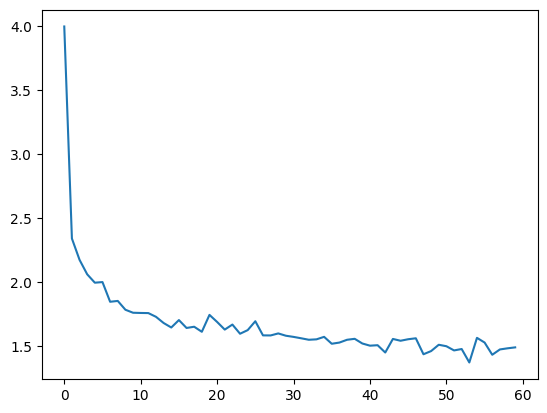

In [23]:
plt.plot(loss_log)

In [30]:
embeddings, targets = [], []

with torch.no_grad():
    for seq in dataset:
        x = collate_feature_dict([seq]).to(model.device)
        emb = model._net.encode(x)
        out = model._net(emb)
        seq_emb = out.max(dim=1).values.squeeze().cpu().numpy()
        embeddings.append(seq_emb)
        targets.append(seq["global_target"])

In [37]:
X = np.array(embeddings)
y = np.array(targets)

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)

y_pred = logreg.predict_proba(X)[:, 1]
roc_auc_score(y, y_pred)

0.7586461042982782